<a href="https://colab.research.google.com/github/Jhansipothabattula/Machine_Learning/blob/main/Day69.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Attention and Multi-Head Attention in Transformers

## Self-Attention Mechanism

* **What is Self-Attention?**
    * Allows a model to dynamically focus on different parts of an input sequence when encoding a token
    * It captures dependencies across all tokens in a sequence, enabling context-aware representations
* **Steps in Self-Attention**
    * Compute Attention Scores:
        * Calculate dot products between the query ($Q$) and key ($K$) vectors for all tokens
        * Scale by the square root of the key dimension ($d_k$) to stabilize gradients
        * Apply the softmax function to convert scores into probabilities
    * Weight Values
        * Use the attention scores to compute a weighted sum of value ($V$) vectors

$$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

## Multi-Head Attention

* **What is Multi-Head Attention?**
    * Applies several attention mechanisms in parallel!
    * Each attention "head" focuses on different aspects of the sequence
* **Steps**
    * Linear Projections
        * Project $Q$, $K$, and $V$ into multiple subspaces using learned weight matrices
    * Apply Self-Attention
        * Perform self-attention for each head independently
    * Concatenate Outputs
        * Combine outputs from all heads
    * Final Linear Projection
        * Project concatenated outputs back into the original dimension

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \dots, \text{head}_h)W_O$$

## Applications of Multi-Head Attention in NLP

* **Machine Translation**
    * Captures dependencies across languages for better translations
* **Text Summarization**
    * Identifies key phrases to generate concise summaries
* **Named Entity Recognition**
    * Focuses on contextual clues to detect entities in text

**Objective**
- Implement a Simplified self-Attention and Multi-Head Attention mechanism and visualize their effects on text sequences

Attention Weights: 
 [[0.32375051 0.17222556 0.2730973  0.23092663]
 [0.25716454 0.24560358 0.22609043 0.27114145]
 [0.31740217 0.17597915 0.28768293 0.21893575]
 [0.25660171 0.20177529 0.20931951 0.33230349]]
Context Vector: 
 [[0.40373714 0.57596851 0.65199056]
 [0.44847108 0.48422419 0.62544482]
 [0.39596332 0.58290558 0.64506672]
 [0.46435514 0.46358349 0.66743626]]
Attention Weights:
 tensor([[[[0.2641, 0.2510, 0.2440, 0.2409],
          [0.2653, 0.2537, 0.2460, 0.2350],
          [0.2715, 0.2560, 0.2431, 0.2295],
          [0.2666, 0.2557, 0.2408, 0.2369]],

         [[0.2503, 0.2540, 0.2519, 0.2438],
          [0.2496, 0.2531, 0.2517, 0.2456],
          [0.2495, 0.2532, 0.2500, 0.2473],
          [0.2478, 0.2490, 0.2505, 0.2527]]]], grad_fn=<SoftmaxBackward0>)
Context Vector:
 tensor([[[-0.2324,  0.3679, -0.7655,  0.5517,  0.0682, -0.1680,  0.3756,
          -0.4036],
         [-0.2329,  0.3678, -0.7669,  0.5516,  0.0680, -0.1678,  0.3762,
          -0.4043],
         [-0.2336, 

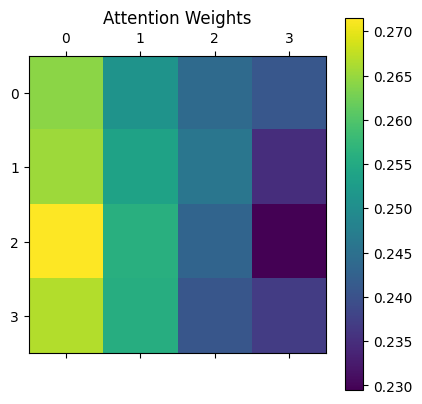

In [4]:
from typing import ChainMap
import numpy as np

# Define query, key and value matrices
def generate_data(seq_len, embed_dim):
    np.random.seed(42)
    return np.random.rand(seq_len, embed_dim)

sequence_length = 4
embedding_dim = 3

query = generate_data(sequence_length, embedding_dim)
key = generate_data(sequence_length, embedding_dim)
value = generate_data(sequence_length, embedding_dim)

# Compute attention scores
scores = np.dot(query, key.T) / np.sqrt(embedding_dim)

# Apply softmax to normalize scores
def softmax(scores):
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    return exp_scores / exp_scores.sum(axis=-1, keepdims=True)

attention_weights = softmax(scores)

# Compute weighted values
weighted_values = np.dot(attention_weights, value)

print("Attention Weights: \n", attention_weights)
print("Context Vector: \n", weighted_values)

import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)
        # Linear projections
        q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention_weights = torch.softmax(scores, dim=-1)

        # Compute context
        context = torch.matmul(attention_weights, v).transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        return self.out(context), attention_weights

# Sample input
seq_len, embed_dim = 4, 8
x = torch.rand(1, seq_len, embed_dim)

# Instantiate and test
mha = MultiHeadAttention(embed_dim, num_heads=2)
context, attn_weights = mha(x)
print("Attention Weights:\n", attn_weights)
print("Context Vector:\n", context)

import matplotlib.pyplot as plt

# Visulaize attention weights for a single head
plt.matshow(attn_weights[0, 0].detach().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Attention Weights")
plt.show()